In [1]:
pip install openpyxl



[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd

xls = pd.ExcelFile("E-commerce_data.xlsx")

customers = pd.read_excel(xls, sheet_name='customers')
genders = pd.read_excel(xls, sheet_name='genders')
cities = pd.read_excel(xls, sheet_name='cities')
transactions = pd.read_excel(xls, sheet_name='transactions')
branches = pd.read_excel(xls, sheet_name='branches')
merchants = pd.read_excel(xls, sheet_name='merchants')

customers.head(), genders.head(), cities.head(), transactions.head(), branches.head(), merchants.head()


(   customer_id  join_date  city_id  gender_id
 0            1 2022-01-08        7          1
 1            2 2023-05-02       20          2
 2            3 2023-05-14       15          1
 3            4 2022-11-25       11          2
 4            5 2023-04-26        8          1,
    gender_id gender_name
 0          1        Male
 1          2      Female,
    city_id         city_name
 0        1             Cairo
 1        2        Alexandria
 2        3              Giza
 3        4  Shubra El-Kheima
 4        5         Port Said,
    transaction_id  customer_id transaction_date transaction_status  \
 0               1          733       2024-05-11         subscribed   
 1               2          631       2023-05-15             burned   
 2               3          309       2022-11-13         subscribed   
 3               4          695       2024-01-26         subscribed   
 4               5          288       2022-10-12             burned   
 
   coupon_name  burn_date  br

In [6]:
data = customers.merge(genders, on='gender_id').merge(cities, on='city_id')
transactions_summary = transactions.groupby('customer_id').agg(
    total_transactions=('transaction_id', 'count'),
    burned_coupons=('transaction_status', lambda x: (x == 'burned').sum())
).reset_index()

data = data.merge(transactions_summary, on='customer_id', how='left').fillna(0)

data.head()


,customer_id,join_date,city_id,gender_id,gender_name,city_name,total_transactions,burned_coupons
0,1,2022-01-08,7,1,Male,Mansoura,7.0,3.0
1,2,2023-05-02,20,2,Female,Sohag,3.0,1.0
2,3,2023-05-14,15,1,Male,Aswan,5.0,1.0
3,4,2022-11-25,11,2,Female,Ismailia,1.0,0.0
4,5,2023-04-26,8,1,Male,El-Mahalla El-Kubra,4.0,3.0


In [7]:
data_encoded = pd.get_dummies(data[['gender_name', 'city_name', 'total_transactions', 'burned_coupons']], drop_first=True)

data_encoded.head()


,total_transactions,burned_coupons,gender_name_Male,city_name_Aswan,city_name_Asyut,city_name_Beni Suef,city_name_Cairo,city_name_Damanhur,city_name_Damietta,city_name_El-Mahalla El-Kubra,...,city_name_Ismailia,city_name_Mansoura,city_name_Minya,city_name_Port Said,city_name_Qena,city_name_Shubra El-Kheima,city_name_Sohag,city_name_Suez,city_name_Tanta,city_name_Zagazig
0,7.0,3.0,True,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
1,3.0,1.0,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,5.0,1.0,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1.0,0.0,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
4,4.0,3.0,True,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

scores = []
range_n_clusters = range(2, 11)
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    preds = clusterer.fit_predict(data_encoded)
    score = silhouette_score(data_encoded, preds)
    scores.append(score)

optimal_clusters = range_n_clusters[np.argmax(scores)]
optimal_clusters, scores


(2,
 [np.float64(0.3900649720391472),
  np.float64(0.3033940176129122),
  np.float64(0.26289953728613624),
  np.float64(0.23543944242754378),
  np.float64(0.20759462502694992),
  np.float64(0.1944507336384207),
  np.float64(0.19554502916141764),
  np.float64(0.1745372816291591),
  np.float64(0.16933820758626894)])

In [9]:
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
data['cluster'] = kmeans_final.fit_predict(data_encoded)

data.head()


,customer_id,join_date,city_id,gender_id,gender_name,city_name,total_transactions,burned_coupons,cluster
0,1,2022-01-08,7,1,Male,Mansoura,7.0,3.0,0
1,2,2023-05-02,20,2,Female,Sohag,3.0,1.0,1
2,3,2023-05-14,15,1,Male,Aswan,5.0,1.0,1
3,4,2022-11-25,11,2,Female,Ismailia,1.0,0.0,1
4,5,2023-04-26,8,1,Male,El-Mahalla El-Kubra,4.0,3.0,1


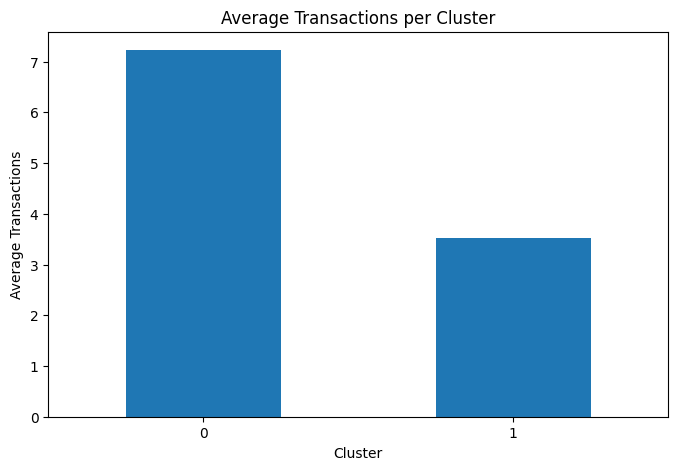

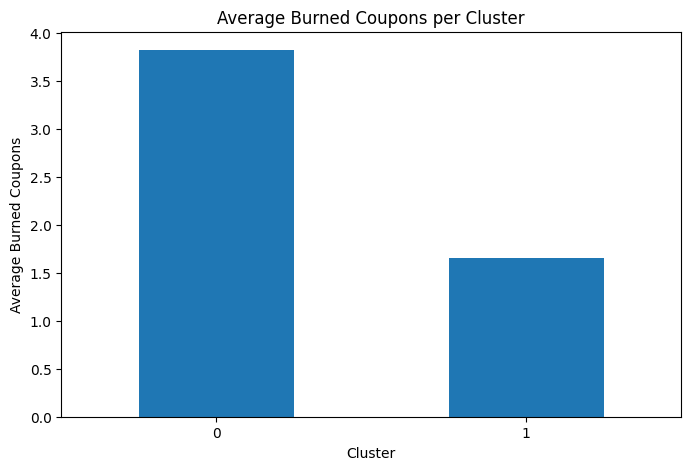

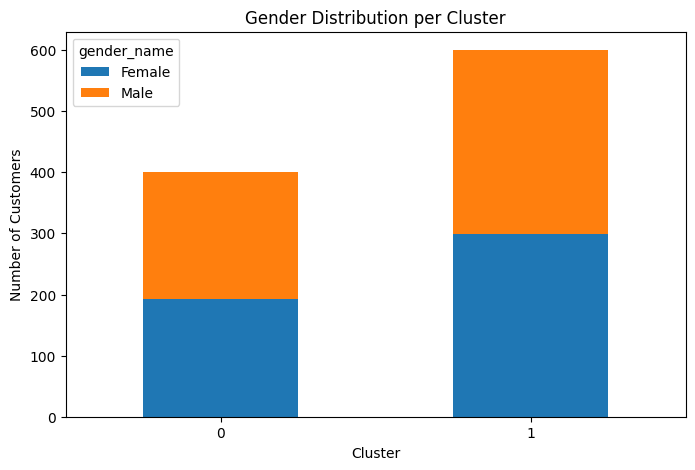

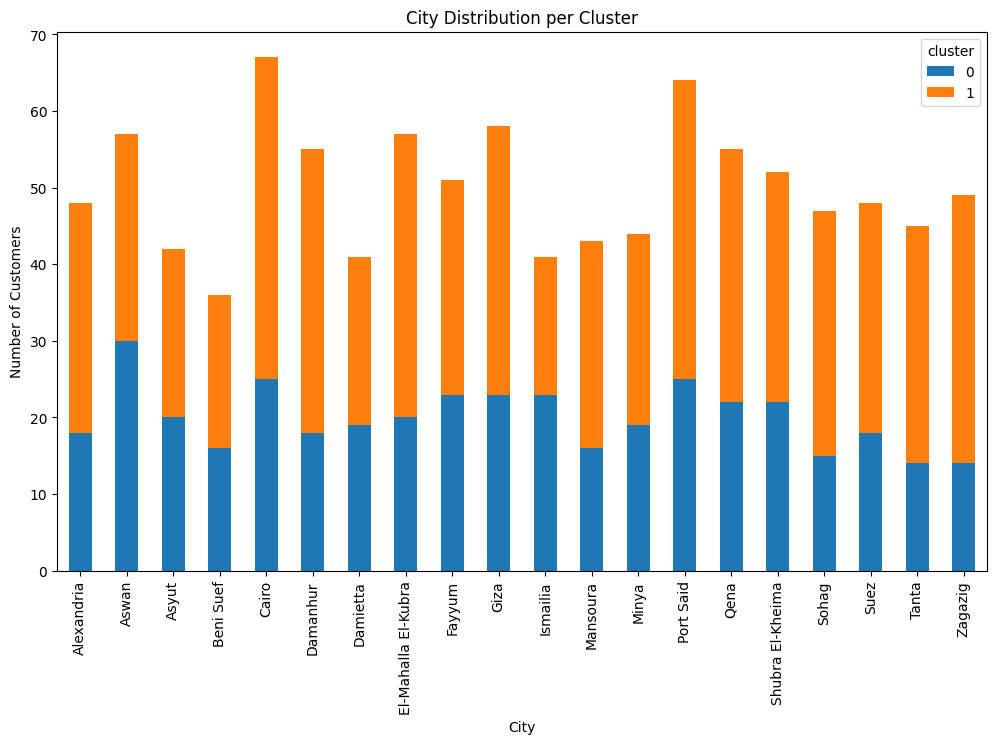

,Cluster,Average Transactions,Average Burned Coupons,Customers Count,Recommendations
0,Cluster 0,7.2275,3.817500,400,Customers with moderate engagement. Offer peri...
1,Cluster 1,3.5150,1.648333,600,Highly engaged customers. Implement loyalty pr...


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

cluster_analysis = data.groupby('cluster').agg({
    'total_transactions': 'mean',
    'burned_coupons': 'mean',
    'customer_id': 'count'
}).rename(columns={'customer_id': 'num_customers'})

gender_distribution = data.groupby(['cluster', 'gender_name']).size().unstack()
top_cities_per_cluster = data.groupby(['cluster', 'city_name']).size().unstack().T

# متوسط المعاملات لكل مجموعة
plt.figure(figsize=(8, 5))
cluster_analysis['total_transactions'].plot(kind='bar', title='Average Transactions per Cluster')
plt.ylabel('Average Transactions')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

# متوسط استخدام الكوبونات لكل مجموعة
plt.figure(figsize=(8, 5))
cluster_analysis['burned_coupons'].plot(kind='bar', title='Average Burned Coupons per Cluster')
plt.ylabel('Average Burned Coupons')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

# توزيع الجنس في كل مجموعة
gender_distribution.plot(kind='bar', stacked=True, figsize=(8, 5), title='Gender Distribution per Cluster')
plt.ylabel('Number of Customers')
plt.xlabel('Cluster')
plt.xticks(rotation=0)
plt.show()

# المدن لكل مجموعة
top_cities_per_cluster.plot(kind='bar', stacked=True, figsize=(12, 7), title='City Distribution per Cluster')
plt.ylabel('Number of Customers')
plt.xlabel('City')
plt.xticks(rotation=90)
plt.show()

segment_recommendations = pd.DataFrame({
    'Cluster': ['Cluster 0', 'Cluster 1'],
    'Average Transactions': cluster_analysis['total_transactions'].values,
    'Average Burned Coupons': cluster_analysis['burned_coupons'].values,
    'Customers Count': cluster_analysis['num_customers'].values,
    'Recommendations': [
        'Customers with moderate engagement. Offer periodic coupons and targeted discounts to increase transactions.',
        'Highly engaged customers. Implement loyalty programs and exclusive offers to maintain satisfaction and loyalty.'
    ]
})

display(segment_recommendations)
